# Autoregressive models

## Preparing the data

For the first part of this lab session, we will use textual data, since this will allow us to have faster training times, more efficient models and more enjoyable results. On the one hand, training RNNs on images is generally resource-heavy because of their high dimensionality and complex structure. On the other hand, we cannot just use vanilla RNN architectures for images, since these will produce unsatisfying results &ndash; you should rather resort to architectures should as [PixelRNN](https://arxiv.org/abs/1601.06759) or [DRAW](https://arxiv.org/abs/1502.04623), but these are challenging to train and out of scope for this lab session. And as will become clear later on in this course, autoregressive models are generally not the preferred family of models to generate images.

We will use the data from (almost) all of **Shakespeare's plays**. We have already assembled them together in a single txt file by crawling [Project Gutenberg](https://www.gutenberg.org/). The entire file is approximately 6.1 MB large, and can be downloaded into the `content` folder of this Colab notebook by executing the following script:

In [244]:
#!wget https://raw.githubusercontent.com/cedricdeboom/character-level-rnn-datasets/master/datasets/shakespeare.txt

In the first part of this lab session, we will train a so-called **character-level RNN**. This means that we will operate on the character level of the text, and not on the word level, i.e. a single token is a separate character in the text and we will generate the text one character at a time. We do this again to optimize the computational footprint and efficiency of the model, since there are much less unique characters than unique words in a text.

### Assignment 1

Since neural networks only operate on numerical data, we have to be able to convert our text into such numerical format.

1. Calculate the length (in no. of characters) of the entire dataset.
2. Create a collection of all the unique characters in the dataset and calculate its size.
3. Inspect the collection of unique characters. Are there any strange or unwanted characters? Remove them from the collection.
4. Create two data structures that can be used to map each unique character onto a unique integer index, and vice versa. These will be used to convert between a text and a sequence of numbers.
5. Since the dataset is not that large, we will keep the entire dataset in memory for quick access. Store the data as a single numerical (NumPy) array, thereby making use of the char-to-index map you created before. Make sure the array stores integers and not floats.

If you want to further increase the efficiency of the model (and reduce the data dimensionality), you can first convert the entire dataset to lowercase letters, but this is not obligatory.

In [245]:
import numpy as np
import pandas as pd 
import torch
from torch.utils.tensorboard import SummaryWriter



CUDA_LAUNCH_BLOCKING=1    #Cuda set to synchronous
torch.manual_seed(7777)
np.random.seed(7777)

In [246]:
url = "shakespeare.txt"

with open(url, 'r') as f:
    text = f.read()
n_char = [len(line) for line in text] 
print("Number of total characters: {}".format(sum(n_char)))

Number of total characters: 6347703


In [247]:
from collections import Counter

cnt = Counter(text)
print("Size of collection: {}".format(len(cnt)))
for char, count in cnt.items():
    print(f'{char}: {count}')

Size of collection: 83
﻿: 1
1: 133
6: 31
0: 17
3: 73

: 156771
A: 47187
L: 23215
S: 32543
 : 1423312
W: 18635
E: 38081
T: 40896
H: 18780
N: 27633
D: 13714
b: 56691
y: 103636
i: 239083
l: 176223
a: 295203
m: 115670
h: 264508
k: 35720
e: 489267
s: 259529
p: 56224
r: 253212
t: 349659
P: 11075
o: 341127
n: 259646
K: 7326
I: 58687
G: 12182
O: 30522
F: 12050
R: 26234
C: 20529
U: 15398
B: 15127
M: 15933
,: 100379
u: 138922
f: 82885
d: 162191
w: 88783
v: 40811
g: 68965
V: 3700
c: 80790
.: 84543
:: 11966
;: 20791
': 36868
j: 3253
Y: 8546
?: 12845
-: 9655
!: 10976
x: 5089
q: 2958
[: 2071
]: 2063
z: 1430
2: 81
": 450
Q: 1408
J: 2162
4: 33
5: 43
Z: 730
7: 9
X: 492
&: 24
9: 26
<: 28
8: 6
(: 122
): 121
}: 2
_: 2
$: 1


From the list above, characters 

In [248]:
# Remove unwanted char


#####

In [249]:
chars = set(text)
#print(len(chars))

char_to_id = {char:i for i, char in enumerate(chars)}
id_to_char = {i:char for i, char in enumerate(chars)}

print("Chars mapped to id: {}".format(char_to_id))
print("Id mapped to char: {}".format(id_to_char))

Chars mapped to id: {'R': 0, 'm': 1, '\ufeff': 2, 'I': 3, 'u': 4, 'X': 5, 't': 6, ',': 7, 'C': 8, '7': 9, 'b': 10, 'i': 11, '&': 12, '}': 13, 'G': 14, '"': 15, ';': 16, 'c': 17, ']': 18, 'S': 19, 'h': 20, ' ': 21, 'Q': 22, 'Z': 23, '[': 24, 'O': 25, 'a': 26, 'y': 27, '4': 28, '!': 29, '9': 30, 'r': 31, '(': 32, '8': 33, 'V': 34, '\n': 35, "'": 36, 'v': 37, 'f': 38, 's': 39, 'M': 40, '1': 41, 'N': 42, 'w': 43, 'L': 44, 'x': 45, 'l': 46, 'D': 47, '5': 48, '$': 49, 'F': 50, '3': 51, 'W': 52, 'T': 53, 'z': 54, ')': 55, 'o': 56, 'p': 57, 'A': 58, 'n': 59, 'j': 60, 'J': 61, ':': 62, 'k': 63, 'E': 64, 'd': 65, '0': 66, 'P': 67, '-': 68, '.': 69, '?': 70, '_': 71, '2': 72, 'g': 73, 'K': 74, '<': 75, 'Y': 76, 'U': 77, 'q': 78, 'B': 79, '6': 80, 'e': 81, 'H': 82}
Id mapped to char: {0: 'R', 1: 'm', 2: '\ufeff', 3: 'I', 4: 'u', 5: 'X', 6: 't', 7: ',', 8: 'C', 9: '7', 10: 'b', 11: 'i', 12: '&', 13: '}', 14: 'G', 15: '"', 16: ';', 17: 'c', 18: ']', 19: 'S', 20: 'h', 21: ' ', 22: 'Q', 23: 'Z', 24: '

In [250]:
text_ids = [char_to_id[char] for char in text]

data = np.array(text_ids, dtype=np.int32)
print(data.shape)
print(type(data))

(6347703,)
<class 'numpy.ndarray'>


## Representing and batching the data

When we represent characters as integers, we implicitly define an ordering between the characters: character 0 is close to character 1, but farther away from character 35. This is unwanted: the distance between each character in the feature space should ideally be the same. For this reason we will use a so-called **one-hot encoding** of each character. This is a vector of all zeros, except for a 1 at the index position of the considered character. For example: if we have 4 unique characters, character 0 is one-hot encoded as `[1,0,0,0]`, character 1 as `[0,1,0,0]`, character 2 as `[0,0,1,0]` and character 3 as `[0,0,0,1]`.

As you know, neural networks are (traditionally) trained with stochastic gradient descent. This means that the data must be delivered in batches at the input of the network. For sequential data this means that the data becomes 3-dimensional: if $B$ is the batch size, $T$ is the sequence length and $D$ is the data dimensionality, then each batch has shape $(B, T, N)$. Note that this immediately implies that within a batch, all sequences must have the same length $T$. Does is done by either:

 * Only taking chunks of length $T$ from the dataset to fill up the batch, or
 * Also taking chunks of length $\leq T$, and filling up the remainder of the sequences with invalid data (padding).

Since our entire dataset is essentially one long sequence, we can always sample chunks of length $T$, so we will take the (simpler) first approach.

### Assignment 2

Create a custom Dataset class for the Shakespeare data (see lab 1 for more details). For this purpose, write appropriate `__init__`, `__len__` and `__getitem__` methods. Make sure that you can specify the desired sequence length $T$ and data dimensionality $D$. You can take different approaches:

 * Divide the dataset in chunks of equal length $T$ e.g. by following the truncated backpropagation through-time (TBPTT) parameterizations (see lecture). You can then calculate how many sequences your dataset counts.
 * Return a random chunk whenever `__getitem__` is called. This is more versatile than the approach above and leads to smoother loss minimization, but you lose the notion of an "epoch". In this case, you can return whatever (large) number you want in the `__len__` method (e.g. `sys.maxsize` returns a large integer number).

Remember that you also have to return the training target labels for a sequence in the `__getitem__` method! Think again about what the task is ("predict the next character in a sequence") and then decide what the labels should be. Again you have different possibilities (see lecture: single-loss training vs. multi-loss training). Let's pick **multi-loss training** for now: in that case the target labels should also be a sequence.

Make sure that the input data is one-hot encoded (this is not needed for the target labels) and that your data has dtype float32 (single precision; which is the PyTorch default for neural network parameters)!

Initialize an instance of a DataLoader and test your Dataset class.

In [251]:
from torch.utils.data import Dataset, DataLoader
import sys
import torch.nn.functional as F

class TextDataset(Dataset):
    def __init__(self, data, seq_length, dim):
      self.data = data
      self.seq_length = seq_length
      self.dim = dim

    def __getitem__(self, index):
      start_index = torch.randint(0, len(self.data) - self.seq_length - 1, (1,)).item()
      
      input_seq = torch.LongTensor(self.data[start_index:start_index+self.seq_length])
      #print(type(input_seq))
      
      #One-hot encoding, hope casting to float() is the way to go (used it in the labs of ML-NLP and worked fine)
      input_seq = F.one_hot(input_seq, num_classes = self.dim).float()

      #Multi-loss training predicts for each char the next char, so the target for char i is i+1
      target_seq = self.data[start_index+1:start_index+self.seq_length+1]
      target_seq = torch.LongTensor(target_seq)

      return input_seq, target_seq

    def __len__(self):
      return len(self.data)

In [252]:
dataset = TextDataset(data, 100, 128)
dataloader = DataLoader(dataset)
for i, (input_seq, target_seq) in enumerate(dataloader):
    print(input_seq.shape)
    print(target_seq.shape)
    print(input_seq)
    print(target_seq)
    break

torch.Size([1, 100, 128])
torch.Size([1, 100])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[21, 58, 17, 17, 56,  4, 59,  6, 81, 65, 21, 65, 26, 59, 73, 81, 31, 56,
          4, 39, 21, 38, 56, 46, 46, 27, 69, 21, 52, 20, 27, 21,  6, 20, 81, 59,
          7, 21, 26, 46, 26, 39,  7, 35, 21, 21, 21, 21, 47, 56, 21,  3, 21, 57,
          4,  6, 21,  4, 57, 21,  6, 20, 26,  6, 21, 43, 56,  1, 26, 59, 46, 27,
         21, 65, 81, 38, 81, 59, 39, 81,  7, 35, 21, 21, 21, 21, 53, 56, 21, 39,
         26, 27, 21,  3, 21, 20, 26, 37, 81, 21]])


## Building the model

We will now build the recurrent neural network in PyTorch that will be trained to predict the next character in a given sequence of characters. We will leverage GRU layers as the main building blocks, but you can experiment with other layers as well. You can find more information on Pytorch's recurrent layers on [https://pytorch.org/docs/master/nn.html#recurrent-layers](https://pytorch.org/docs/master/nn.html#recurrent-layers).

### Assignment 3

A diagram of the envisioned architecture is shown in the picture below. Implement this architecture by inheriting from `torch.nn.Module`, as was explained in Lab 1. Test your module by getting a batch of data, feed it trough the network, and check if a sensible output is produced (especially if you have implemented the softmax - see remark 2 below - check if your output is properly normalized).

<img src='https://drive.google.com/uc?id=19Q4T7vhZtbdwrf4cS0SwPi3DqSZKqVSX' width='500' />

The one-hot encoded input sequence is fed through two GRU layers with 128 hidden states. The outputs of the last GRU layer are fed through two dense layers. The first dense layer has a (leaky) ReLU output activation (but you can experiment with other ones as well). The final dense layer has an output dimensionality of $D$ and calculates a softmax over all possible characters. The parallel arrows indicate that each layer calculates an output at every time step. Of course, the dense layers do not have a recurrent nature and do not process a sequence in its entirety: each input of the dense layer is processed separately of the others and leads to its own output. But it was cleaner to draw the diagram this way.

**Important remark 1**: The Pytorch recurrent layers have a `batch_first` argument that you ideally set to `True`. That way, the first data dimension is considered the batch dimension.

**Important remark 2**: For the softmax nonlinearity, you can either choose to leave it out of the model during training and offload its computation to the CrossEntropyLoss object later (as done in Lab 1). Or you can choose to attach the log-softmax nonlinearity and make it part of the model. This will have implications on the loss function that will be used during training (see later). It's up to you, but please make sure that you know what you are doing!

**Important remark 3**: The initial hidden state $\mathbf{h}_0$ of your GRU layers is initialized as a vector of zeroes, as a PyTorch default. It is, however, possible to parameterize the initial hidden states and train these parameters; if you are interested in this, you can search through the documentation or on the internet how you can achieve this (not obligatory).

In [253]:
from torch import nn

class model(nn.Module):
  def __init__(self, input_size, output_size):
    torch.nn.Module.__init__(self)
    self.gru = nn.GRU(input_size= input_size, hidden_size= 128, num_layers=2, batch_first=True)
    self.linear1 = nn.Linear(128, 128)
    self.linear2 = nn.Linear(128, output_size)
  
  def forward(self,x, device, h_0=None):
    if h_0 is None:
      h_0 = self.init_hidden(x.size(0)).to(device)
    x,h = self.gru(x, h_0)
    x = F.relu(self.linear1(x))
    x = self.linear2(x)   #Optional to add softmax here or after, from little bit of research, if using CrossEntropyLoss, more stable if using after
    return x,h
  
  def init_hidden(self, batch_size):
        hidden = torch.zeros(2, batch_size, 128)
        return hidden

## Training the model

Now that we have the dataset and the model ready, it is time to train our very first character-level RNN!

### Assignment 4

Write an optimization procedure to train the RNN from assignment 3 using the data and batching strategy from assignments 1 and 2. We advise you to use the **Adam** optimizer with learning rate 0.001, which has become one of the default optimizers in deep learning, especially if you don't want to spend much time figuring out an effective learning rate schedule for plain SGD (which generally can lead to better optimizations). Pick a large enough batch size, e.g. 128, and a sequence length $T$ of around 100. Around 50 epochs of 1000 batches should be enough for now to train this model until "reasonable" convergence. Make sure to put the model and each batch on the GPU.

**Important remark**: those of you who left out the log-softmax from the model, will need to use a CrossEntropyLoss. If you did use a log-softmax, you need a NLLLoss. Please read the documentation carefully regarding the use of these loss functions. Since we use **multi-loss training** we have a classification target at each time step, i.e. $T$ different loss values for each entry in the batch. Find out how to *correctly(!)* combine these losses into a single number (they can be averaged or summed, but make sure this is done along the correct axis). Another option (instead of using the built-in loss functions) is to write the loss criterion yourself in a separate function; this can be a nice exercise.

In [254]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [255]:
from torch.optim import Adam

batch_sz = 128
seq_length = 100
max_batches = 1000

dataset = TextDataset(data, seq_length, batch_sz)
dataloader = DataLoader(dataset, batch_size=batch_sz)

net = model(128,100).to(device)

optimizer = Adam(net.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss(reduction='mean')

In [256]:
num_epochs = 50
running_loss = 0.0

for epoch in range(num_epochs):
  for i, (input_seq, target_seq) in enumerate(dataloader):
    if i >= max_batches:
      break
    
    input_seq = input_seq.to(device)
    target_seq = target_seq.long().to(device)
    #net.to(device)

    net.train()      
    optimizer.zero_grad()
  
    output_seq,_ = net(input_seq, device)
    output_seq = output_seq.squeeze(2).to(device)
    #print(output_seq.shape)
    #print(target_seq.shape)

    loss = criterion(output_seq, target_seq)

    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      print(f'Epoch {epoch+1}, Batch {i+1}: Loss = {running_loss/100}')
      running_loss = 0.0


Epoch 1, Batch 100: Loss = 4.41580864906311
Epoch 1, Batch 200: Loss = 4.236726734638214
Epoch 1, Batch 300: Loss = 4.129626007080078
Epoch 1, Batch 400: Loss = 4.228134317398071
Epoch 1, Batch 500: Loss = 4.217038342952728
Epoch 1, Batch 600: Loss = 4.084767379760742
Epoch 1, Batch 700: Loss = 4.2203296327590945
Epoch 1, Batch 800: Loss = 4.001786603927612
Epoch 1, Batch 900: Loss = 4.020499904155731
Epoch 1, Batch 1000: Loss = 4.298617770671845
Epoch 2, Batch 100: Loss = 4.462708854675293
Epoch 2, Batch 200: Loss = 4.4114288187026975
Epoch 2, Batch 300: Loss = 4.3746475410461425
Epoch 2, Batch 400: Loss = 4.362972826957702
Epoch 2, Batch 500: Loss = 4.304222812652588
Epoch 2, Batch 600: Loss = 4.151317224502564
Epoch 2, Batch 700: Loss = 4.004475512504578
Epoch 2, Batch 800: Loss = 4.263199882507324
Epoch 2, Batch 900: Loss = 4.046539099216461
Epoch 2, Batch 1000: Loss = 4.290927665233612
Epoch 3, Batch 100: Loss = 4.279857568740844
Epoch 3, Batch 200: Loss = 4.164784784317017
Epoch 

In [257]:
torch.save(net.state_dict(), "./model.pth")

## Generating text

In the previous assignment, our RNN was trained to predict the next character in a given sequence. We will now use this trained RNN in generator mode to produce text on its own. Since we have used multi-loss training, we have multiple options for the sampling strategy: either progressive sampling or windowed sampling, which each have their own benefits and flaws (see lecture). Also, it often depends on the framework that you use (in our case PyTorch) which of the sampling strategies is more easy to implement.

### Assignment 5

We will implement **progressive sampling**. We will start from a seed sequence of 100 characters after which we let the RNN generate the subsequent characters ad libitum (you can choose how many characters you want the RNN to generate). We also want to be able to tune the randomness in the model by means of a **softmax temperature** parameter. The plan is as follows:

 1. Sample a random seed sequence of $T$ characters from the dataset and feed it through the RNN.
 2. Consider the softmax output of the final time step, and use it to sample the next character in the sequence (`torch.multinomial` might come in handy).
 3. Feed the recently sampled character through the RNN, but make sure that the RNN starts from the last hidden state of step 1! For this to work, you will need to change the model definition such that you can specify the initial hidden state, and such that the final hidden state can be captured when a sequence is fed through the RNN. Look in the documentation on how to achieve this.
 4. Iterate from step 2 until enough characters are sampled.

Test your sampler with different temperature values and different seed sequences. If all went right, observe that the model has learned to create words, separated by spaces, and that it has learned that there are character roles which are often written in uppercase letters. Also observe that the RNN is pretty good at generating language on a low level, but that it fails to produce coherent texts on a larger scale.

**Important remark 1**: make sure that your input data still has a batch dimension. If this is not the case, take a look at the `unsqueeze` function to add extra dimensions to your data.

**Important remark 2**: you will have to change the `forward`-method of the model class such that a softmax temperature can be specified as an extra argument.

**Important remark 3**: since you will be changing the model class, it is advised to store the parameters of the already trained RNN. You can then load these parameters into your updated model object.

**Important remark 4**: if you specify a random seed, your results will be reproducible, which might be handy.

1. Get initial index as random number between 0 and length of data - T - 1
2. From this first index you get the following consecutive T elements
3. As the previous list will be a list of numbers, each corresponding to a char, you need to one-hot encode this list
4. Then this sequence is feeded to the model (so it is predicting the next char from the previous list)
5. The output sequence is divided by the temperature (so data is smoothed) and feeded to softmax 
6. Then can't I just get the max arg of the softmax, why exactly is torch.multinomial needed? sample from the distribution better results, but softmax should work
7. Then the softmax will give us the position of the char in data 
8. From the position we can get its corresponding value, and so the corresponding char from its id
9. And then the loop starts again, however only feeding the next generated char.

In [258]:
inference_model = model(128,100).to(device)
inference_model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [259]:
#device = torch.device("cpu")
#print(device)

In [260]:
def progressive_sampling(rnn, dataset, T, num_samples, temperature, device):
  rnn.eval()    
  
  start_index = torch.randint(0, len(dataset.data) - T - 1, (1,)).item()
  seed_seq = dataset.data[start_index:start_index+T]
  
  seed_seq = torch.LongTensor(seed_seq).to(device)
  
  seed_seq = F.one_hot(seed_seq, dataset.dim).float()   #Model needs one-hot enc. of data
  #print("Seed sequence shape: " + str(seed_seq.shape))  # = (100,128)
  
  output_seq,hn = rnn(seed_seq.unsqueeze(0), device)    # seed_seq-> (1,100,128)
  #print("Output sequence shape: " + str(output_seq.shape))  # = (1,100,100)

  softmax_output = F.softmax(output_seq/temperature, dim=2)  #Temperature is used for smoothing, so higher value more uniform dist.
  #print('Softmax output shape: ' + str(softmax_output))     # = (1,100,100)

  #next_char = torch.multinomial(softmax_output.squeeze(1),1)   #Multinomial sampling, so we get a random char from the distribution
  next_char = softmax_output.argmax()
  #print("Next char index: " + str(next_char))

  next_char_id = data[int(next_char)]
  #print("Next char id: " + str(next_char_id))
  

  #print("Character generated: "+id_to_char[next_char_id])  
  generated_seq = [id_to_char[next_char_id]]

  for i in range(0,num_samples-1):
    next_char_id = torch.LongTensor([next_char_id]).to(device)

    one_hot_char = F.one_hot(next_char_id, dataset.dim).float()
    #print("One hot shape: " + str(one_hot_char.unsqueeze(0).shape)) # = (1,1,128)

    output_seq,hn = rnn(one_hot_char.unsqueeze(0), device, hn)
    #print("Output seq shape: " + str(output_seq))
    
    softmax_output = F.softmax(output_seq/temperature, dim=2)
    #print('Softmax output shape: ' + str(softmax_output.squeeze(1).squeeze(0).shape))   # = (1,1,100)
    
    next_char = torch.multinomial(softmax_output.squeeze(1).squeeze(0), 1)    #=(100)
    #next_char = softmax_output.argmax()
    #print("Next char index: " + str(next_char))

    next_char_id = data[int(next_char)]
    #print("Character generated: "+id_to_char[next_char_id])  

    generated_seq.append(id_to_char[next_char_id])

  return ''.join(generated_seq)


In [261]:
print(progressive_sampling(inference_model, dataset, 100, 100, 1, device))
#print(progressive_sampling(net, dataset, 100, 100, 1, device))

w6666666666666666666666666666666666





﻿﻿


66
6
0666600606
0
0





































## Evaluating generative language models

Generative models can be evaluated by looking at either the likelihood of the predictions, or by looking at the sample quality. Both methods have their pros and cons &ndash; and as we will see in the lecture about generative adversarial networks, they are not necessarily correlated! &ndash; and usually a combination of the two is used in literature. 

In the previous assignment we have looked at (subjective) sample quality, in the following assignment we will look at a likelihood-based metric. For this metric, it is important that we calculate it on a separate test set. After all, at this point we don't know if the RNN has learned all training data by heart, or if it can truly generalise on unseen data from the true data distribution.

A popular performance measure for language models is the **perplexity**:
$$\text{perplexity} = \exp\left(  \frac{-\sum_{t=1}^N \log p(x_t \vert x_{1:t-1})}{N} \right)$$
To calculate perplexity, we feed the entire test set ($N$ tokens in total) through the RNN and we calculate the log-likelihood of each ground-truth token. Lower perplexity means better model performance on unseen data.

### Assignment 6

1. Split the original dataset into a train and test set. Take around 10,000 characters for the test set (e.g. the last part of the dataset).

2. Write a routine that calculates perplexity on this held-out test set. Start by feeding in the first character of the test set into the RNN, record the log-likelihood, and then iterate by going through the entire test sequence. Think about how you can make this routine as fast and efficient as possible (where do you put the data (cpu/gpu), when do you convert it to one-hot, etc.).

3. Retrain the RNN and record perplexity on the test set after every epoch. Visualize the train and test metrics on a Tensorboard. Do you observe signs of overfitting? Or can we manage more than 50 training epochs?

In [262]:
#Split dataset into train and test
test_data = data[-1000:]
train_data = data[:-1000]


In [283]:
def perplexity(net, test_data, dim, device):
    test_data = F.one_hot(torch.LongTensor(test_data), dim).float().to(device)
    #print(test_data.shape)
    net.train(False)
    log_likelihood = 0.0
    
    #hn = net.init_hidden()
    for i in range(0,len(test_data)-1):
        #print(test_data[i].unsqueeze(0).unsqueeze(0).shape)
        output_seq,_ = net(test_data[i].unsqueeze(0).unsqueeze(0), device)

        #                           output_seq(only vocab size))      indexes resulting tensor 
        log_likelihood += torch.log(output_seq.squeeze(0).squeeze(0)[test_data[i+1].argmax()]) 
    
    net.train(True)
    perp = torch.exp(-log_likelihood/len(test_data))
    return perp

In [269]:
perp = perplexity(inference_model, test_data, dataset.dim, device)
print("Perplexity: " + str(perp.item()))

Perplexity: 0.18348021805286407


In [299]:
writer = SummaryWriter('runs/shakespeare_rnn_3')

In [300]:
batch_sz = 128
seq_length = 100
max_batches = 1000

train_dataset = TextDataset(train_data, seq_length, batch_sz)
train_dataloader = DataLoader(train_dataset, batch_size=batch_sz)

model_q6 = model(128,100).to(device)

optimizer = Adam(model_q6.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss(reduction='mean')

In [301]:
num_epochs = 100
running_loss = 0.0

for epoch in range(num_epochs):
  for i, (input_seq, target_seq) in enumerate(train_dataloader):
    if i >= max_batches:
      break
    
    #print(input_seq)
    #print(target_seq)
    input_seq = input_seq.to(device)
    target_seq = target_seq.long().to(device)
    #net.to(device)

    model_q6.train(True)      
    optimizer.zero_grad()

  
    output_seq,_ = model_q6(input_seq, device)
    output_seq = output_seq.squeeze(2).to(device)
    #print(output_seq.shape)
    #print(target_seq.shape)

    loss = criterion(output_seq, target_seq)
    
    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    if i % 100 == 99:
      print(f'Epoch {epoch+1}, Batch {i+1}: Loss = {running_loss/100}')
      writer.add_scalar('training loss', running_loss/100, epoch * len(train_dataloader) + i)
      running_loss = 0.0

  perp = perplexity(model_q6,test_data, dataset.dim, device)  
  print('Perplexity: ' + str(perp.item()))
  writer.add_scalar('perplexity', perp.item(), epoch * len(train_dataloader) + i)
  
  

Epoch 1, Batch 100: Loss = 4.422628021240234
Epoch 1, Batch 200: Loss = 4.245744936466217
Epoch 1, Batch 300: Loss = 4.264159157276153
Epoch 1, Batch 400: Loss = 4.2442040801048275
Epoch 1, Batch 500: Loss = 4.043417706489563
Epoch 1, Batch 600: Loss = 4.3906347370147705
Epoch 1, Batch 700: Loss = 4.346500878334045
Epoch 1, Batch 800: Loss = 4.162537477016449
Epoch 1, Batch 900: Loss = 4.0529959416389465
Epoch 1, Batch 1000: Loss = 4.086500804424286
Perplexity: 4.1069183349609375
Epoch 2, Batch 100: Loss = 4.1348285436630245
Epoch 2, Batch 200: Loss = 3.909710202217102
Epoch 2, Batch 300: Loss = 3.9570893931388853
Epoch 2, Batch 400: Loss = 4.087050559520722
Epoch 2, Batch 500: Loss = 4.211577525138855
Epoch 2, Batch 600: Loss = 3.972165684700012
Epoch 2, Batch 700: Loss = 3.891926712989807
Epoch 2, Batch 800: Loss = 4.254721019268036
Epoch 2, Batch 900: Loss = 4.008171308040619
Epoch 2, Batch 1000: Loss = 3.8554366183280946
Perplexity: 1.7450543642044067
Epoch 3, Batch 100: Loss = 4.1

Initial evaluation (50 epochs):

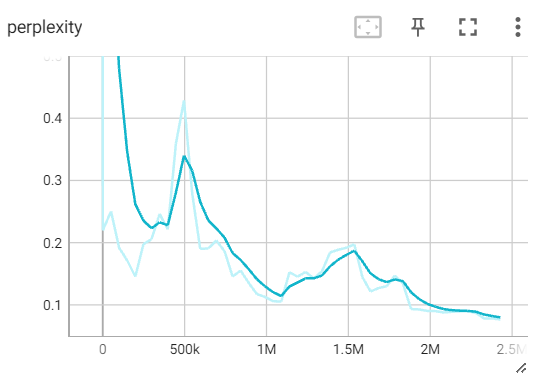
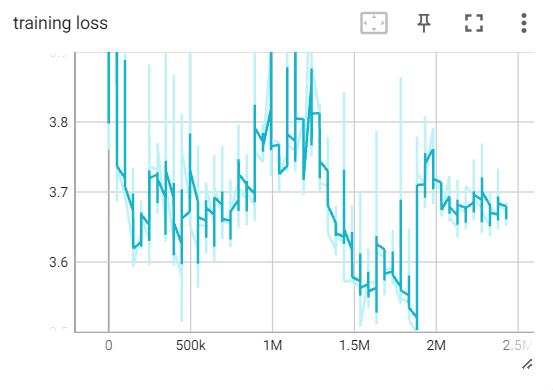


From the graphs we can conclude that the model is in fact learning as perplexity and loss decrases for each epoch. This is not as clear only analyzing the loss as the loss is not as smooth, but perplexity helps visualize this better. However I do think the model can be furthered trained as the loss and perplexity are still decreasing.

## Extra ideas

You are now finished with the lab session. If you want to do some more experiments, you could try:

 * Alter the model architecture: try LSTM instead of GRU, add or remove some of the recurrent layers, play with the dimensionality of the layers, etc.
 * Insert a so-called [embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding) after the input layer. This layer takes integers as input, so you will need to get rid of the one-hot representations. Alternatively, you could insert a dense layer (without bias) after the one-hot input layer, which will behave as an embedding layer (think about what calculation a dense layer actually performs, and how it behaves if the input is a one-hot vector: is there any difference with an embedding layer?).
 * Try windowed sampling instead of progressive sampling (this is usually **easier** to implement, but leads to slower sampling times and has a more limited receptive field).
 * Try top-K sampling, nucleus sampling or beam search.
 * Try single-loss training, or try multi-loss training but weight the loss linearly across the entire sequence, i.e. attach little weight to the first tokens, and more weight to tokens later in the sequence.
 * Try temporal convolutions.
 * Try generating text on a word level instead of the character level. For this to work well you will need to do some preprocessing of the text first: tokenization, removal of punctuation, conversion of all characters to lowercase, etc. Then proceed by making an indexed vocabulary, but replace all the words that occur less than e.g. 10 times by an `<UNK>` token (for "unknown"). Also alter the architecture of the model by including an embedding layer after the input layer, which will generally lead to better results. Training time of such a model will be longer than a character-level model.